<a href="https://colab.research.google.com/github/jschmidt345/data_analytics_ml/blob/master/Dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# End to end multi-class dog breed classification
 
This notebook uses image classifier via Tensorflow 2.0 and Tensorflow hub. 

### 1. Problem

Identify breed of dog given image 

### 2. Data 

Via kaggle's dog breed identification competition

### 3. Evaluation

The Evaluation is a file with dog breeds and the corresponding p(dog breed = 1)

### 4. Features

* image data (unstructured)
* best we use deep learning / transfer learning
* 120 breeds of dogs (120 different classes)
* Around 10000+ images in training set (have labels)
* Around 10000+ images in test set
(no labels)

In [ ]:
# unzipping data
#/content/drive/My Drive/dog_vision_folder/dog-breed-identification.zip

### Get our workspace ready

* import Tensorflow 2.2.0 
* import Tensorflow Hub
* Make sure we're using a GPU


In [ ]:
# Import necessary tools into google colab
import tensorflow_hub as hub
import tensorflow as tf
print("TF Version", tf.__version__)
print('Hub version', hub.__version__)

# Check for GPU availability 
print('GPU', 'available (yes!)' if tf.config.list_physical_devices('GPU') else "not allowed")

TF Version 2.2.0
Hub version 0.8.0
GPU available (yes!)


### Getting data ready (turning img to tensors)

Start by accessing data and checking labels

In [ ]:
import pandas as pd
labels_csv = pd.read_csv('/content/drive/My Drive/dog_vision_folder/labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     4023851ba15301e077734449d0c78eba  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


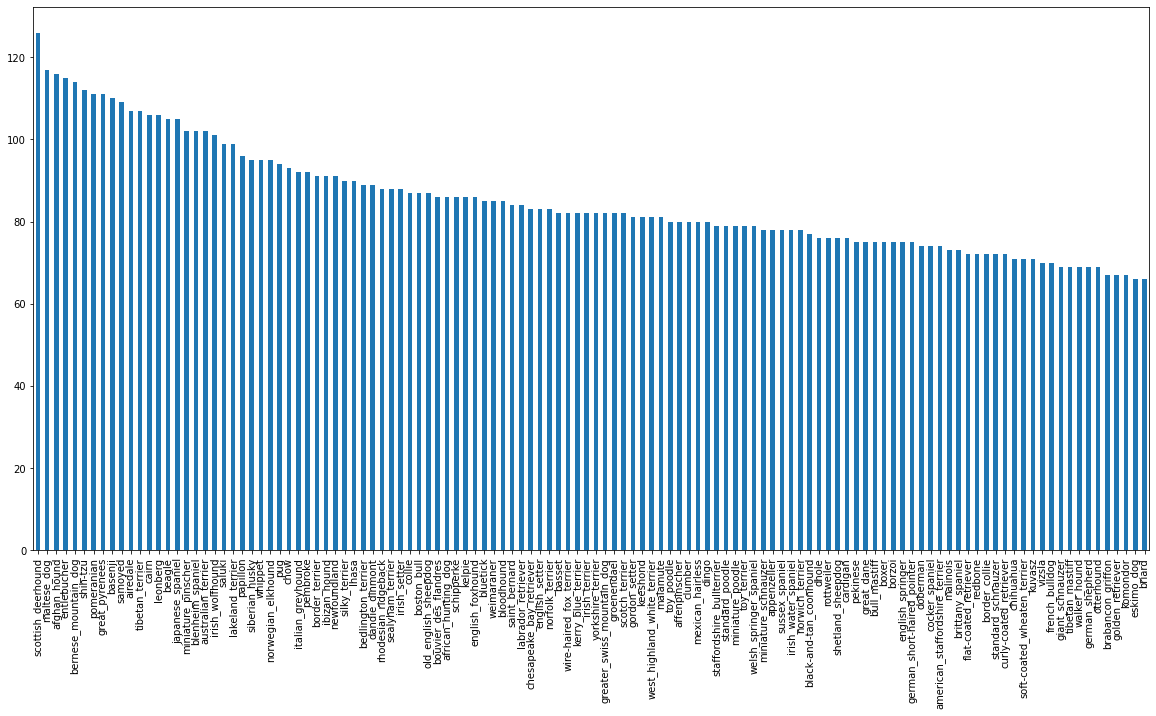

In [ ]:
# How many images per dog breed
labels_csv['breed'].value_counts().plot(kind='bar', figsize=(20, 10))

In [ ]:
# median number of samples per dog breed 
labels_csv['breed'].value_counts().median()

82.0

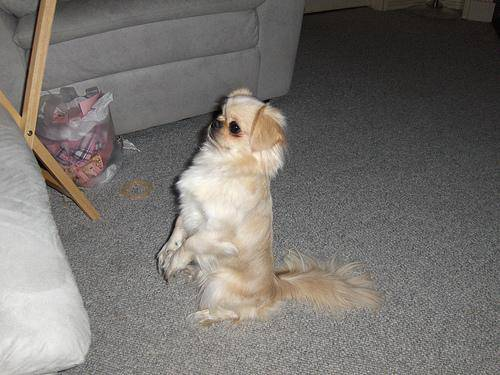

In [ ]:
# lets view an img
from IPython.display import Image
Image('drive/My Drive/dog_vision_folder/train/001cdf01b096e06d78e9e5112d419397.jpg')

### Getting images and their labels

Get list of all our img file pathnames

In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
# Create pathnames from img id's
filepaths = ['drive/My Drive/dog_vision_folder/train/' + fname + '.jpg' for fname in labels_csv['id']]

# check first 10
filepaths[:10]

['drive/My Drive/dog_vision_folder/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/dog_vision_folder/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/dog_vision_folder/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/dog_vision_folder/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/dog_vision_folder/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/dog_vision_folder/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/dog_vision_folder/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/dog_vision_folder/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/dog_vision_folder/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/dog_vision_folder/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# check if there are enough filenames
import os
if len(os.listdir('drive/My Drive/dog_vision_folder/train/')) == len(filepaths):
  print('Looks good')
else:
  print('error import data, not correct amount')

KeyboardInterrupt: ignored

Since we now have our training img paths in a list, lets prepare our labels

In [ ]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
len(labels)

10222

In [ ]:
# See if len(labels) == len(paths)
if len(labels) == len(filepaths):
  print('no missing data')

no missing data


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
  # Turn a single label into an array of booleans
  print(labels[0])
  labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# turn every label into bool arr
boolean_labels = [label == unique_breeds for label in labels]

In [ ]:
# Example: Turning boolean array into integers
print(labels[0]) # og label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in bool array
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set 


In [ ]:
# Set up X and y
X, y = filepaths, boolean_labels

Start off experimenting with 100 images and increase as needed

In [ ]:
#Set n of images used for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# use scikit train and validation split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Lets look at training data
X_train[:5], y_train[:5]

(['drive/My Drive/dog_vision_folder/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/dog_vision_folder/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/dog_vision_folder/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/dog_vision_folder/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/dog_vision_folder/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, Fa

## Preprocessing images (converting images to tensors)

Write function that:
- Take image filepath as input
- Use TensorFlow to read file and save it to a variable, `image`
- Turn our `image` into Tensors
- Normalize our image -> (0 - 255) -> (0 - 1)
- Resize the `image` to be a shape of (224, 224)
- Return the modified `image`


In [ ]:
# Convert image to numpy array
from matplotlib.pyplot import imread, imshow
image = imread(filepaths[42])

In [ ]:
# turn img into tensor
tf.constant(image)[:2]

In [ ]:
# Define img size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes img file path and converts it to a Tensor.
  """
  # Read in img file
  image = tf.io.read_file(image_path)

  # Turn the jpeg into numerical Tensor with 3 color channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channel values from 0 - 255, 0 - 1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the img
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

## Turning our data into batches

Why turn our data into batches?

Trying to process 10000+ imgs in one go....might not all fit into memory

Need to transform data into Tensor tuples which look like : 
`(image, label)`


In [ ]:
# create function that returns a tuple (img, label)
def get_image_label(image_path, label):
  """
  Takes image file path and label,
  processes the image and returns tuple
  """
  image = process_image(image_path)

  return image, label

Now we have a way to turn our data into tuples of tensors (img, label)

Now make function to turn all of our data into batches

In [ ]:
# Define the batch size, 32 is good start
BATCH_SIZE = 32

# create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if its training data but doesnt shuffle if it is validation data.
  Also accepts test data as input (no labels).
  """

  # If data is test, we dont probably dont have labels
  if test_data:
    print('Creating test data batches')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch 
  
  # if data is validation set, do not need to shuffle it
  elif valid_data:
    print('Creating validation batch')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  # if data is training set
  else:
    print('Creating training data batches...')
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices(((tf.constant(X),
                                               tf.constant(y))))
    # Shuffling pathnames and labels before maping image processor function is faster than after
    data = data.shuffle(buffer_size=len(X))

    # create (image, label) tuples (also turns img path into a preprocessed img)
    data = data.map(get_image_label)

    # turn training dta into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch
                                    

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation batch


In [ ]:
# check out differing attributes
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

  ## Visualizing data batches

In [ ]:
import matplotlib.pyplot as plt

# create function for viewing batches
def show_25_imgs(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """

  # set up figure
  plt.figure(figsize=(10, 10))
  # loop through 25 for displaying 25 imgs
  for i in range(25):
    # create subplots (5, 5)
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    # add img label as title
    plt.title(unique_breeds[labels[i].argmax()]) 
    # turn grid line off
    plt.axis('off')

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())

In [ ]:
# now visualize training 
show_25_imgs(train_images, train_labels)

## Building a model 

Before we build a model, there are a few things we need to define:
1. the input shape (our image shape in the form of tensors)
2. the output shape (image labels, in the form of tensors)
3.using https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [ ]:
# setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

# setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TF hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'



Now we have our inputs, outputs, and model ready. Now put them together into a Keras deep learning model!

Create function that 
- takes input shape, output shape and model we have chosen as params.
- Defines the layers in a Keras model in sequential fashion
- compiles model
- build the model (tells the model the input shape)
- returns the model

In [ ]:
# Create a function which builds a keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print('Building model with:', MODEL_URL)

  # setup model layers
  model = tf.keras.Sequential([
  hub.KerasLayer(MODEL_URL), 
  tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                        activation='softmax') 
  ])
  
  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # higher loss, worse predictions
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions that a model can use during training to save and check progress, or stop training model early if model is not improving

Two callbacks:
1. For TensorBoard
2. Early stoppage (prevents overtraining)

### TensorBoard Callback

To setup TB callback, need to do 3 things:

1. Load the TB notebook extension
2. Create a TB callback that can save logs to a dir, and pass it to our model's fit function
3. Visualize our models traning logs



In [ ]:
# load tensorboard notebook extension
%load_ext tensorboard

In [ ]:
import datetime, os

# Create a function to build a TB callback
def create_tb_callback():
  # create a log dir for storing TB logs
  logdir = os.path.join('drive/My Drive/dog_vision_folder/logs',
                        # make it so logs get tracked when we run experiment
                        datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
  
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping prevents overfitting

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)


## Training a model (on subset of data)

First model is only going to train on 1k images

In [ ]:
NUM_EPOCHS = 10 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# one last gpu active check
print("GPU", "available" if tf.config.list_physical_devices("GPU") else 'GPU off')

GPU available


Create function which trains a model

* Create model using `create model()`
* set up TB callback
* Call the fit() function on our model passing it the traning dta, valid dta, and n of epochs to train for
* Return the model

In [ ]:
# Build a function to train and return trained model

def train_model():
  '''
  Trains a given model and returns the trained model
  '''
  # Create model
  model = create_model()

  # Create new TB session everytime we train model
  tensorboard = create_tb_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data, 
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  return model

In [ ]:
# fit model to data
model = train_model()


Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/10
25/25 [==============================] - 395s 16s/step - loss: 4.7610 - accuracy: 0.0850 - val_loss: 3.4948 - val_accuracy: 0.2550
Epoch 2/10
25/25 [==============================] - 4s 170ms/step - loss: 1.7390 - accuracy: 0.6525 - val_loss: 2.2489 - val_accuracy: 0.4750
Epoch 3/10
25/25 [==============================] - 4s 166ms/step - loss: 0.5953 - accuracy: 0.9350 - val_loss: 1.7247 - val_accuracy: 0.5700
Epoch 4/10
25/25 [==============================] - 4s 167ms/step - loss: 0.2645 - accuracy: 0.9862 - val_loss: 1.5237 - val_accuracy: 0.6100
Epoch 5/10
25/25 [==============================] - 4s 168ms/step - loss: 0.1502 - accuracy: 0.9950 - val_loss: 1.4438 - val_accuracy: 0.6050
Epoch 6/10
25/25 [==============================] - 4s 167ms/step - loss: 0.1018 - accuracy: 1.0000 - val_loss: 1.3875 - val_accuracy: 0.6250
Epoch 7/10
25/25 [==============================] - 4s 

### Checking the TensorBoard logs

In [ ]:
%tensorboard --logdir /content/drive/My\ Drive/dog_vision_folder/logs

Reusing TensorBoard on port 6006 (pid 1549), started 0:01:49 ago. (Use '!kill 1549' to kill it.)

<IPython.core.display.Javascript object>

## Making and evaluating predictions using a trained model

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)

# array of arrays that contain p(dog breed label == true label)
predictions

7/7 [==============================] - 1s 106ms/step


array([[1.19850540e-03, 4.79520131e-05, 1.51203165e-03, ...,
        2.10633501e-03, 2.96973685e-05, 3.76257929e-03],
       [1.02281373e-03, 2.37025291e-04, 2.26710807e-03, ...,
        6.29600778e-04, 1.00513687e-03, 2.07128876e-04],
       [3.38978571e-05, 1.63973644e-04, 1.13860275e-04, ...,
        4.69558072e-05, 3.79366174e-05, 6.69873727e-04],
       ...,
       [5.43098067e-05, 7.16340001e-05, 3.51918170e-05, ...,
        1.09424454e-05, 1.64534067e-04, 9.13534241e-05],
       [1.58618379e-03, 2.87345138e-05, 6.68887651e-06, ...,
        2.98446230e-05, 2.75797411e-05, 1.49751455e-03],
       [4.96845169e-04, 6.03696790e-05, 1.77773426e-03, ...,
        7.86974281e-03, 1.24685362e-03, 2.21574199e-04]], dtype=float32)

In [ ]:
sum(predictions[0])

1.000000080569862

In [ ]:
# First prediction
index = 120
print(predictions[index])
print(f'Max value probability{predictions[index].max()}')
print(f'Sum: {np.sum(predictions[index])}')
print(f'Max index: {np.argmax(predictions[index])}')
print(f'Predicted label: {unique_breeds[np.argmax(predictions[index])]}')

[8.0215663e-04 2.7718960e-04 1.0378816e-03 1.3617880e-04 1.7572220e-02
 3.2700013e-04 3.1414369e-04 7.8699822e-03 7.6381765e-02 1.5354834e-01
 2.2621658e-03 1.2286843e-04 1.3954021e-03 9.5907580e-03 1.0007550e-02
 1.8905267e-03 2.3318100e-04 2.7960164e-03 2.9294807e-04 8.7303383e-04
 1.2831585e-04 1.2872817e-02 6.2995503e-04 1.1893687e-03 1.2992808e-02
 3.4795443e-03 2.4609250e-04 3.2658800e-03 2.6320142e-03 3.0037397e-04
 3.0692306e-04 2.3397557e-03 6.2582479e-04 3.1882504e-04 5.9754442e-04
 5.0327886e-04 8.7935932e-04 2.1604695e-03 1.9791711e-03 3.7641814e-01
 6.5384281e-04 4.5145344e-04 7.9020169e-03 9.4056490e-04 3.0460602e-03
 5.3306372e-04 1.4314218e-04 1.2638115e-03 1.5916816e-04 3.4633751e-03
 5.8556092e-05 3.4346324e-04 1.0252655e-03 2.4596546e-02 4.0791740e-05
 8.0163078e-03 4.1482117e-04 4.4006706e-04 1.0265434e-04 3.1852521e-04
 1.5285821e-03 7.7987881e-04 1.6972674e-04 5.6538184e-04 1.3948865e-04
 2.7831045e-03 4.5926700e-04 2.2719001e-02 6.8603083e-04 4.6286688e-04
 1.208

In [ ]:
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probs into a label
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

Since our val data is in a batch data set,
we need to un batch it to make predictions, then compare those predictions to true val labels

In [ ]:
 val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# create a function to unbatch a batch dataset

In [ ]:
def unbatchify(data):
  """
  Takes a batched df of (image, label) Tensros and returns separate array of imgs and labels
  """
  images_ub = []
  labels_ub = []

  # loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images_ub.append(image)
    labels_ub.append(unique_breeds[np.argmax(label)])

  return images_ub, labels_ub

# val_imgs, val_labels = unbatchify(val_data)

In [ ]:
# got it right
print(get_pred_label(val_labels[0]))
get_pred_label(predictions[0])

affenpinscher


'cairn'

* Create function that takes in an array of prediction probabilities, an array of truth labels, and an array of images and integers.

* Convert prediction probabilities to a predicted label. 

* Plot predicted label, its predicted probability, the observed label, and the target image on a single plot

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  
  # Change the color of the title depending on if the predictionis correct 
  if pred_label == true_label:
    color = 'green'
  else:
    color='red'

  # Change polot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                   np.max(pred_prob) * 100,
                                   true_label),
                                  color=color)
  


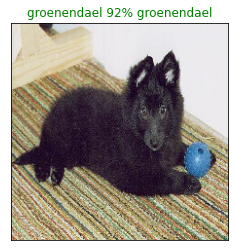

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_imgs,
          n=77) 

Create model to view model's top 10 predictions

Function will:
* Take input of prediction probability arr, observed, and integer
* Find predicted label
* Find top ten:
  * Pred prob indexes
  * Pred prob values
  * Prediction labels

* Plot the top 10 pred probs



In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 highest prediction confidences, along with truth labek for sample n
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # get the pred label
  pred_label = get_pred_label(pred_prob)

  # Find the top ten pred conf indexes
  top_10_pred_indexes = [predictions[n].argsort()[-10:][::-1]]

  # top 10 probabilities
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  
  # find the top 10 pred labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]
  
  # Set up plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                      top_10_pred_values,
                     color='grey')
  plt.xticks(np.arange(len(top_10_pred_labels)),
            labels=top_10_pred_labels,
            rotation='vertical')
  
  # change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
  else:
    pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


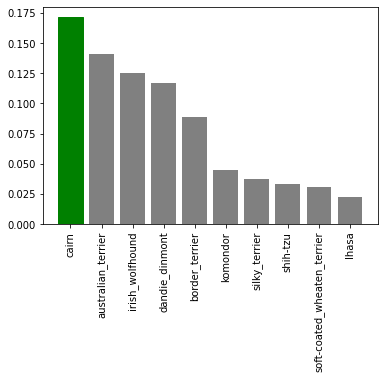

In [ ]:
plot_pred_conf(predictions, val_labels, 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


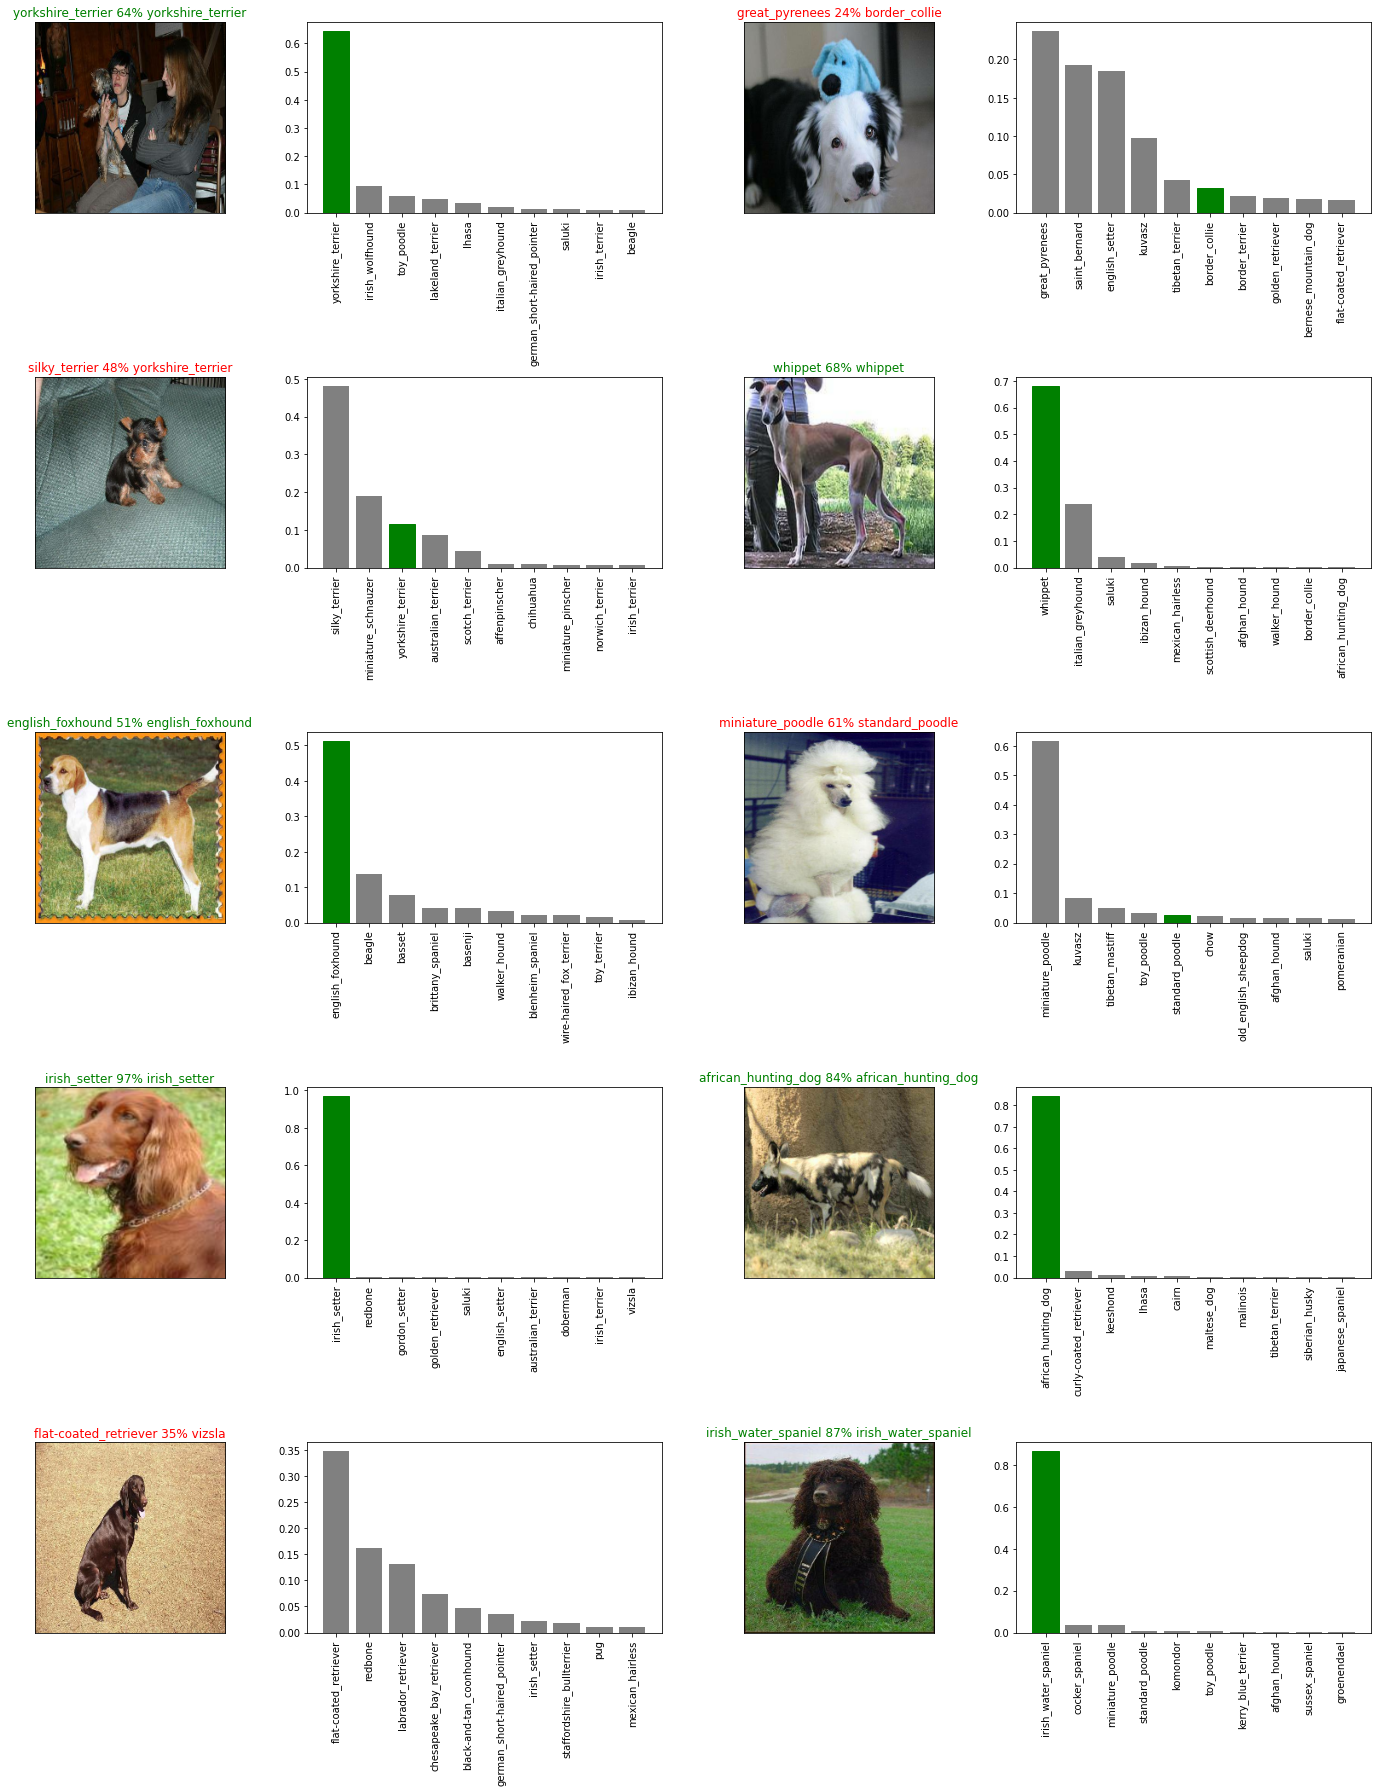

In [ ]:
i_multiplier = 10
num_rows = 5
num_cols = 2
num_imgs = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_imgs):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions, 
            labels=val_labels,
            images=val_imgs,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
  plt.tight_layout(h_pad=1.0)
plt.show()

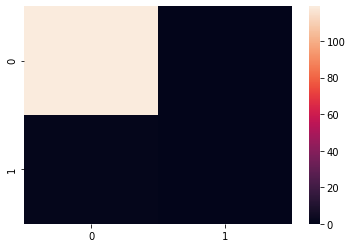

In [ ]:
# # tried to create confusion matrix
# cm = tf.math.confusion_matrix(boolean_labels[0], predictions[3])
# for i in range(len(predictions[18])):
#   if predictions[18][i] == predictions[0].max():
#     predictions[18][i] = 1
#   else:
#     predictions[18][i] = 0
# predictions[0]
# sns.heatmap(tf.math.confusion_matrix(boolean_labels[18], predictions[18]))

## Saving and reloading a model

In [ ]:
import os 

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models dir
  appends a suffix str
  """

  # Create model dir pathname with current time
  modeldir = os.path.join('drive/My Drive/dog_vision_folder/models',
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
  model_path = modeldir + '-' + suffix + '.h5'
  print(f'Saving model to: {model_path}')
  model.save(model_path)
  return model_path

In [ ]:
# Create function to load trained model
def load_model(model_path):
  """loads saved model from path"""

  print(f'Load saved model from {model_path}')
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={'KerasLayer' : hub.KerasLayer})
  return model

In [ ]:
# Save model trained on 1000 imgs
save_model(model, suffix='1000-images-mobilenetv2-Adam')

NameError: ignored

In [ ]:
# Load trained model
loaded_model_1000_imgs = load_model('/content/drive/My Drive/dog_vision_folder/models/20200729-21081596056902-1000-images-mobilenetv2-Adam.h5')

Load saved model from /content/drive/My Drive/dog_vision_folder/models/20200729-21081596056902-1000-images-mobilenetv2-Adam.h5


NameError: ignored

In [ ]:
loaded_model_1000_imgs

In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 104ms/step - loss: 1.3179 - accuracy: 0.6200


[1.317857265472412, 0.6200000047683716]

In [ ]:
# Eval the loaded model
loaded_model_1000_imgs.evaluate(val_data)

7/7 [==============================] - 1s 119ms/step - loss: 1.3179 - accuracy: 0.6200


[1.317857265472412, 0.6200000047683716]

## Training model on full dataset

In [ ]:
len(X), len(y)

(10222, 10222)

In [ ]:
# Create a data batch with the full dataset
full_data = create_data_batches(X, y)


Creating training data batches...


In [ ]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# create model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tb_callback()

# early stopping callback
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                             patience=3)


Model below will take a while

In [ ]:
# Fit the full model to the full data 
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/10
320/320 [==============================] - 4606s 14s/step - loss: 1.3222 - accuracy: 0.6772
Epoch 2/10
320/320 [==============================] - 46s 145ms/step - loss: 0.3992 - accuracy: 0.8829
Epoch 3/10
320/320 [==============================] - 46s 144ms/step - loss: 0.2322 - accuracy: 0.9382
Epoch 4/10
320/320 [==============================] - 46s 143ms/step - loss: 0.1521 - accuracy: 0.9636
Epoch 5/10
320/320 [==============================] - 47s 145ms/step - loss: 0.1070 - accuracy: 0.9780
Epoch 6/10
320/320 [==============================] - 46s 143ms/step - loss: 0.0776 - accuracy: 0.9855
Epoch 7/10
320/320 [==============================] - 46s 143ms/step - loss: 0.0595 - accuracy: 0.9911
Epoch 8/10
320/320 [==============================] - 46s 144ms/step - loss: 0.0464 - accuracy: 0.9941
Epoch 9/10
320/320 [==============================] - 46s 142ms/step - loss: 0.0372 - accuracy: 0.9965
Epoch 10/10
320/320 [==============================] - 45s 142ms/step - l

In [ ]:
save_model(full_model, suffix='full-image-mobilenetv2-Adam')

Saving model to: drive/My Drive/dog_vision_folder/models/20200730-19071596136051-full-image-mobilenetv2-Adam.h5


'drive/My Drive/dog_vision_folder/models/20200730-19071596136051-full-image-mobilenetv2-Adam.h5'

In [ ]:
# load in full model
loaded_full_model = load_model('/content/drive/My Drive/dog_vision_folder/models/20200730-19071596136051-full-image-mobilenetv2-Adam.h5')

Load saved model from /content/drive/My Drive/dog_vision_folder/models/20200730-19071596136051-full-image-mobilenetv2-Adam.h5


## Making predictions on test dataset

Must begin by converting images into Tensor batches

Reminder:
- Get img filename
- Convert filenames into test data batches using `create_data_batches()` and setting the test `test_data` param to True


In [ ]:
# Load test image filenames
test_path = '/content/drive/My Drive/dog_vision_folder/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches


In [ ]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

Calling `predict()` on full model and passing it 10000+ imgs will take a while (1 hr)

In [ ]:
# Make predictions on test data using fully loaded model
test_preds = loaded_full_model.predict(test_data,
                                       verbose=1)


NameError: ignored